## 1. Загрузка данных

Перед нами стоит задача предсказания оттока клиентов оператора связи, т.е. бинарной классификации. Для начала взглянем на данные.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve
from scipy.stats import randint as sp_randint, uniform
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import lightgbm as lgb 

In [2]:
plt.style.use('seaborn-darkgrid')
params = {'axes.titlesize': 18,
          'legend.fontsize': 14,
          'figure.figsize': (15, 6),
          'axes.labelsize': 14,
          'xtick.labelsize': 13,
          'ytick.labelsize': 13,
          'figure.titlesize': 18}
plt.rcParams.update(params)

pd.set_option('display.max_columns', 100)

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Признаки:

- customerID - айди пользователся
- gender - пол
- SeniorCitizen - является ли пенсионером
- Partner - есть ли партнер
- Dependents - является ли иждивенцем
- tenure - срок пользования оператором в месяцах
- PhoneService - пользуется ли услугами телефонии
- MultipleLines - услуга несколько линий
- InternetService - подключен ли интернет
- OnlineSecurity - дополнительная услуга
- OnlineBackup - дополнительная услуга 
- DeviceProtection - дополнительная услуга
- TechSupport - дополнительная услуга
- StreamingTV - дополнительная услуга
- StreamingMovies - дополнительная услуга 
- Contract - переодичность абонентской платы
- PaperlessBilling - безбумажные счета
- PaymentMethod - способ оплаты
- MonthlyCharges - месячные траты
- TotalCharges - траты за весь период 
- Churn - целевой признак, отмечены ушедшие клиенты 

# 2. Предобработка данных

Начнем с того, что проверим данные на дубликаты, избавимся от лишнего столбца customerID и приведем признаки к пододящему типу.

In [5]:
data.duplicated().sum()

0

In [6]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [7]:
cat_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [8]:
# переведем категориальные признаки в category

for feature in cat_features:
    data[feature] = data[feature].astype('category')

In [9]:
# при попытке заменить тип данных TotalCharges на float выдает ошибку, посмотрим что не так

somethingwrong = []
for i in range(len(data.TotalCharges)):
    try:
        float(data.TotalCharges[i])
    except ValueError:
        somethingwrong.append(i)
        
data.loc[somethingwrong]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [10]:
data[data.tenure == 0].index

Int64Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

Видим, что пропуски у только подключившихся абонентов. Имеет смысл удалить их из выборки вовсе, поскольку у таких пользователей еще не было опыта использования продукта и делать прогноз на основе таких данных некорректно.

In [11]:
data = data[data.tenure != 0].reset_index(drop=True)
data.TotalCharges = data.TotalCharges.astype('float')
len(data)

7032

In [12]:
data.Churn = (data.Churn == 'Yes').astype('int')

In [13]:
# поменяю очередность признаков для удобства

data = data[cat_features + num_features + ['Churn']]
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7032 non-null   category
 1   SeniorCitizen     7032 non-null   category
 2   Partner           7032 non-null   category
 3   Dependents        7032 non-null   category
 4   PhoneService      7032 non-null   category
 5   MultipleLines     7032 non-null   category
 6   InternetService   7032 non-null   category
 7   OnlineSecurity    7032 non-null   category
 8   OnlineBackup      7032 non-null   category
 9   DeviceProtection  7032 non-null   category
 10  TechSupport       7032 non-null   category
 11  StreamingTV       7032 non-null   category
 12  StreamingMovies   7032 non-null   category
 13  Contract          7032 non-null   category
 14  PaperlessBilling  7032 non-null   category
 15  PaymentMethod     7032 non-null   category
 16  tenure            7032 n

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,1,29.85,29.85,0
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,34,56.95,1889.50,0
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,2,53.85,108.15,1
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),45,42.30,1840.75,0
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,2,70.70,151.65,1


# 3. Анализ данных

Данные готовы, приступим к анализу.

In [14]:
print('Количество ушедших:', (data.Churn == 1).sum())
print('Доля ушедших:', (data.Churn == 1).sum() / len(data))

Количество ушедших: 1869
Доля ушедших: 0.26578498293515357


Присутствует дисбаланс классов, нужно будет учесть это при обучении.

Посмотрим на распределение категориальных признаков.

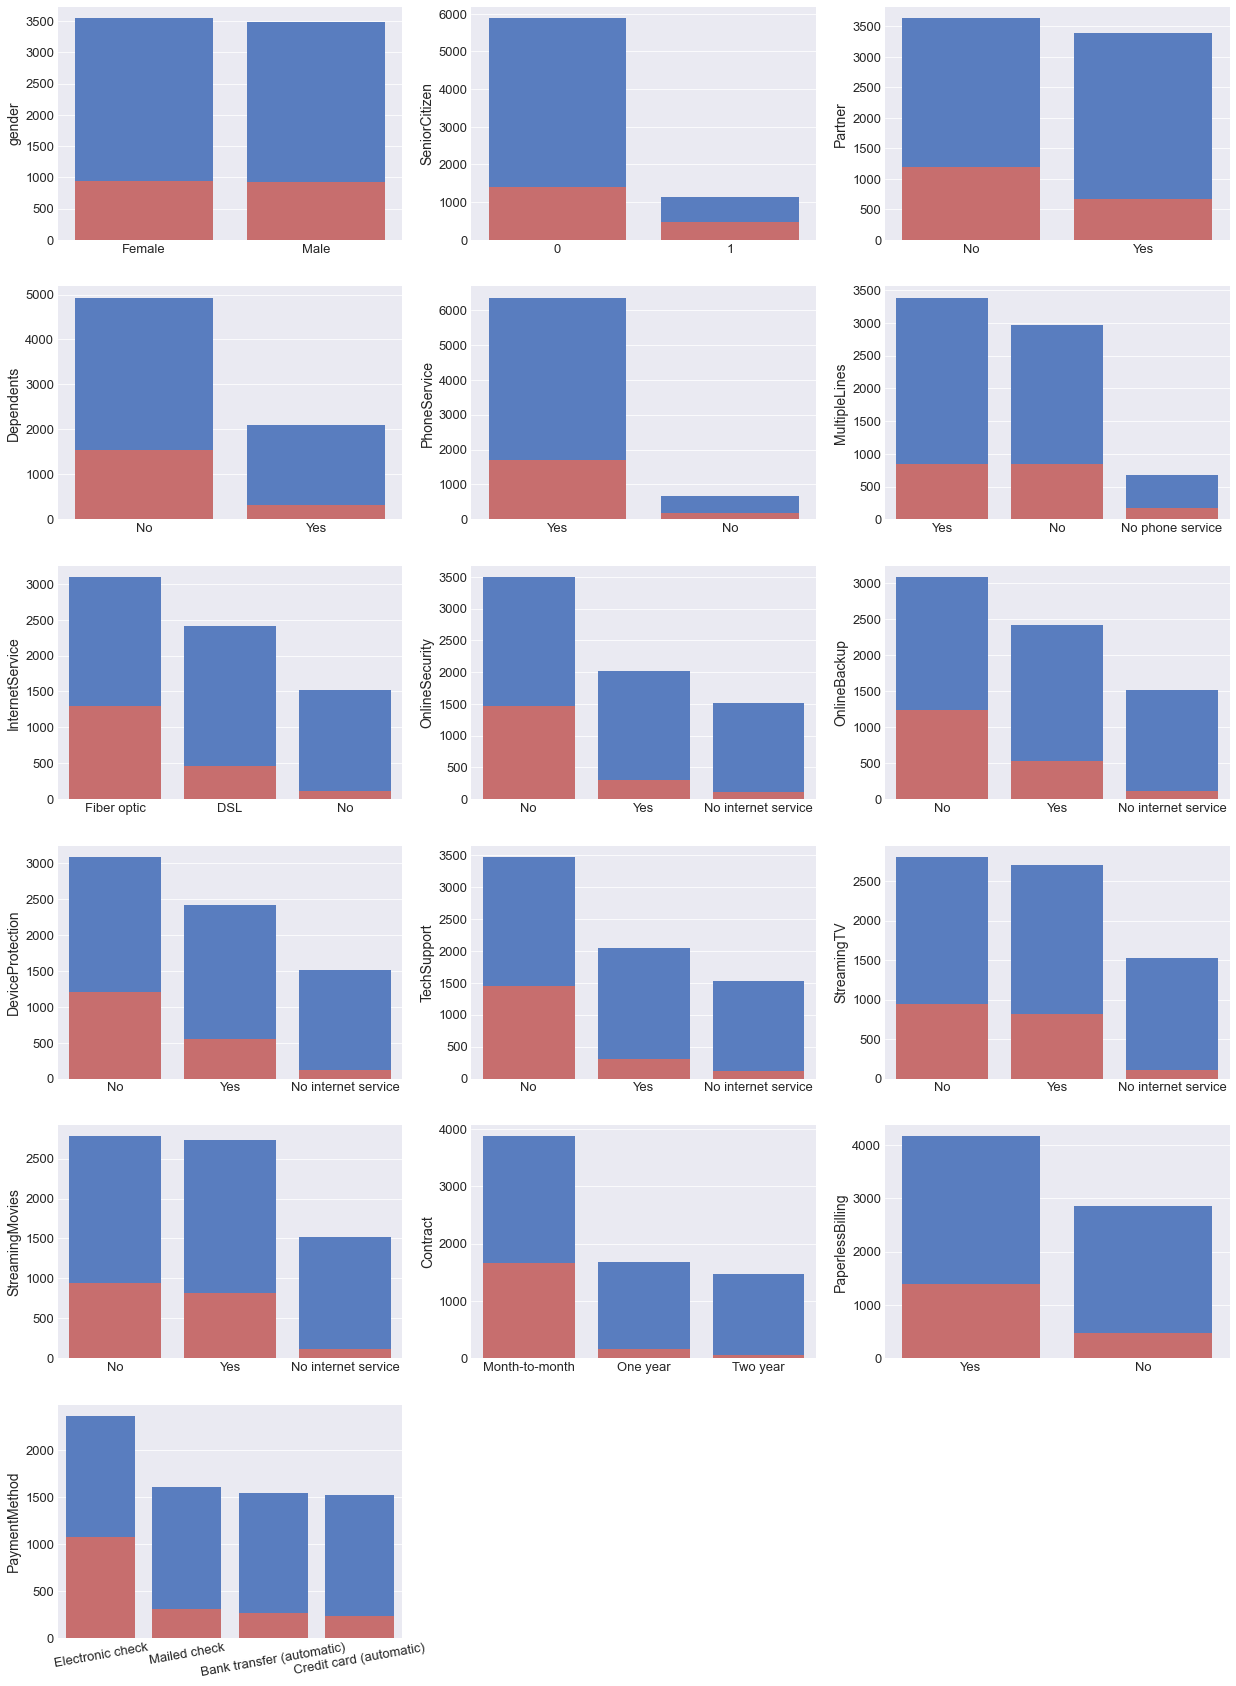

In [15]:
fig = plt.figure(figsize=(21,30))
for i in range(len(cat_features)):
    plt.subplot(6,3,i+1)
    total = data.iloc[:,i].value_counts()
    left = data[data.Churn == 1].iloc[:,i].value_counts()    
    sns.set_color_codes('muted')
    if i == 15:
        plt.xticks(rotation=10)
    sns.barplot(x=total.index.tolist(), y=total, label='All', color='b')
    sns.barplot(x=left.index.tolist(), y=left, label='Left', color='r')
plt.show()

По данными графикам уже можно сделать некоторые выводы о важности признаков - так пол не играет никакого значения сам по себе. А вот срок абонентских платежей, метод оплаты, способ интернет подключения и некоторые дополнительные услуги явно имеют влияние на принятие решения пользователя об уходе. Но вернемся к этому вопросу после обучения моделей и проверки важности признаков.

In [16]:
data.describe()

,tenure,MonthlyCharges,TotalCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441,0.265785
std,24.545260,30.085974,2266.771362,0.441782
min,1.000000,18.250000,18.800000,0.000000
25%,9.000000,35.587500,401.450000,0.000000
50%,29.000000,70.350000,1397.475000,0.000000
75%,55.000000,89.862500,3794.737500,1.000000
max,72.000000,118.750000,8684.800000,1.000000


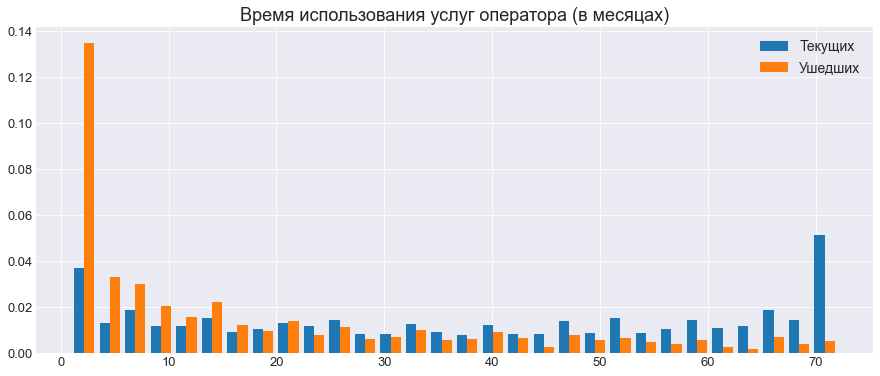

In [17]:
def plot_feature(feature, title):
    zeros = data[data.Churn == 0][feature]
    ones = data[data.Churn == 1][feature]
    plt.hist([zeros, ones], label=['Текущих', 'Ушедших'], bins=30, density=True)
    plt.legend(loc='best')
    plt.title(title)
    plt.show()
    
plot_feature('tenure', 'Время использования услуг оператора (в месяцах)')

Вполне ожидаемое распределение. Большинство уходит в первые месяцы после подключения. Вполне вероятно, что этот признак будет имеет большую роль в предсказаниях.

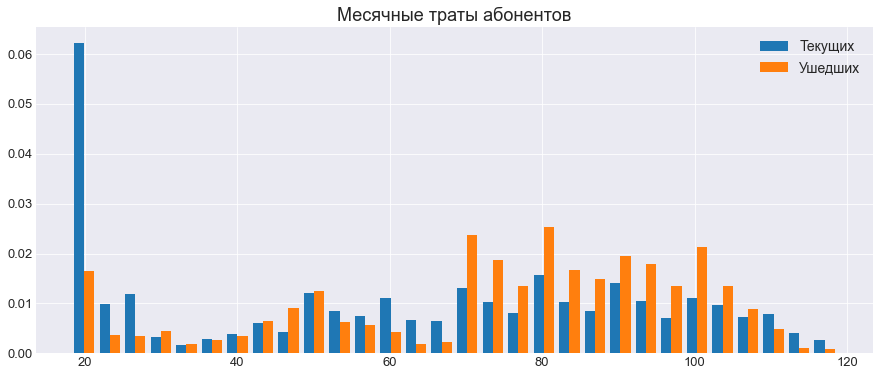

In [18]:
plot_feature('MonthlyCharges', 'Месячные траты абонентов')

Сложно назвать полученные распределение нормальными. Зато здесь можно проследить некоторую сегментацию. Она отлично прослеживается на графике ушедших клиентов. Мы видим пик у минимальных значений, затем в районе 45-60 и скопление в диапазоне 70-110. И если в оставшихся клиентах велика доля тех, кто платит за связь околоминимальную сумму, то в ушедших явно преобладают те, кто приносит доход близкий к максимальному.

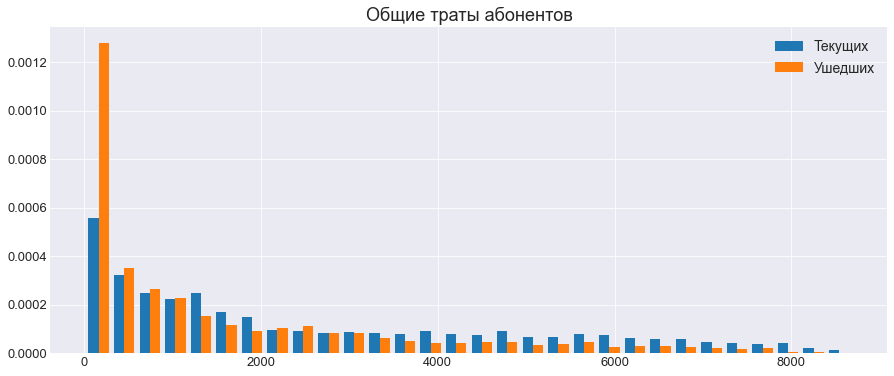

In [19]:
plot_feature('TotalCharges', 'Общие траты абонентов')

Также довольно вероятно, что этот признак может внести существенный вклад в предсказания моделей.

In [20]:
(data.MonthlyCharges * data.tenure).corr(data.TotalCharges)

0.9995598572867933

Возможно, стоит отказаться от какого-то из этих признаков в дальнейшем, чтобы избажать мультиколлинеарности.

# 4. Подготовка данных 

Подготовим количественные и категориальные признаки - первые стандартизируем, вторые преобразуем прямым кодированием. Таким образом мы получим универсальный формат данных, который подойдет всем моделям.

Дисбаланс классов выравнивать не будем - предоставим это делать моделям самостоятельно, указывая соответсвующие гиперпараметры. 

В конце разобьем датасеты на обучающие и отложенные выборки.

In [21]:
# преобразуем категориальные признаки прямым кодированием
ohe = OneHotEncoder(drop='first', dtype='int')
telecom = pd.DataFrame(ohe.fit_transform(data[cat_features]).toarray(), 
                       columns=ohe.get_feature_names(cat_features)).astype('category')
telecom = telecom.join(data[num_features])

# стандартизируем количественные признаки
scaler = StandardScaler()
telecom[num_features] = pd.DataFrame(scaler.fit_transform(telecom[num_features]))

# целевой признак тоже в category
telecom['Churn'] = data['Churn'].astype('category')

print(telecom.info())
telecom.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   gender_Male                            7032 non-null   category
 1   SeniorCitizen_1                        7032 non-null   category
 2   Partner_Yes                            7032 non-null   category
 3   Dependents_Yes                         7032 non-null   category
 4   PhoneService_Yes                       7032 non-null   category
 5   MultipleLines_No phone service         7032 non-null   category
 6   MultipleLines_Yes                      7032 non-null   category
 7   InternetService_Fiber optic            7032 non-null   category
 8   InternetService_No                     7032 non-null   category
 9   OnlineSecurity_No internet service     7032 non-null   category
 10  OnlineSecurity_Yes                     7032 non-null   categ

,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,-1.280248,-1.161694,-0.994194,0
1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0.064303,-0.260878,-0.173740,0
2,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,-1.239504,-0.363923,-0.959649,1


In [22]:
# разобьем полученные выборки на обучающую и отложенную выборки

def split_data(data):
    X = data.drop('Churn', axis=True)
    y = data.Churn
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345, stratify=y)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(telecom)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5274, 30) (1758, 30) (5274,) (1758,)


# 5. Обучение моделей

Наша главная метрика ROC-AUC, но не будем забывать и о других. Попробуем несколько моделе: логистическую регрессию, решающее дерево, метод опорных векторов, метод K-ближайшего соседа, случайный лес и градиентный бустинг.

In [23]:
# напишем нескольно формул для оценки качества моделей и подбора гиперпараметров
    
def random_search(model, params):
    rs = RandomizedSearchCV(model, param_distributions=params, cv=3, 
                            scoring='roc_auc', random_state=12345, n_jobs=-1)
    rs.fit(X_train, y_train)
    print('ROC-AUC score:', rs.best_score_)
    print('Best parameters', rs.best_params_)
    
def grid_search(model, params):
    gs = GridSearchCV(model, params, cv=3, scoring='roc_auc', n_jobs=-1)
    gs.fit(X_train, y_train)
    print('ROC-AUC score:', gs.best_score_)
    print('Best parameters', gs.best_params_)   

def plot_roc(y_true, probabilities):
    fpr, tpr, thresholds = roc_curve(y_true, probabilities)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-curve")
    plt.show()    

metrics = ['Accuracy', 'Recall', 'Precision', 'F1', 'ROC-AUC']
assessment = pd.DataFrame(index=metrics)

def test_model(model, name, threshold=None):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:,1]
    if threshold != None:
        predictions = probabilities > threshold
    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probabilities)
    score = pd.DataFrame({name: [accuracy, recall, precision, f1, roc_auc]}, index=metrics)
    global assessment 
    local = assessment
    assessment = local.join(score)
    print(score)
    plot_roc(y_test, probabilities)

In [24]:
logreg = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=12345, max_iter=400)
logreg_params = {'penalty': ['l1', 'l2']}
grid_search(logreg, logreg_params)

ROC-AUC score: 0.8422889102047758
Best parameters {'penalty': 'l1'}


             LogReg
Accuracy   0.746303
Recall     0.813704
Precision  0.514208
F1         0.630182
ROC-AUC    0.853052


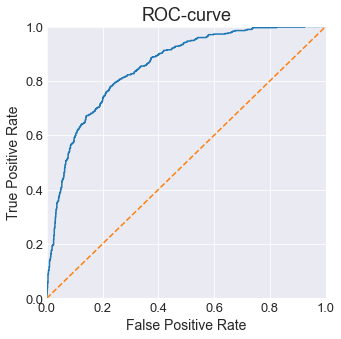

In [25]:
logreg = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', random_state=12345)
test_model(logreg, 'LogReg')

In [26]:
svc = SVC(class_weight='balanced', random_state=12345)
svc_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
grid_search(svc, svc_params)

ROC-AUC score: 0.8371676795848413
Best parameters {'kernel': 'linear'}


                SVC
Accuracy   0.704778
Recall     0.852248
Precision  0.469340
F1         0.605323
ROC-AUC    0.850541


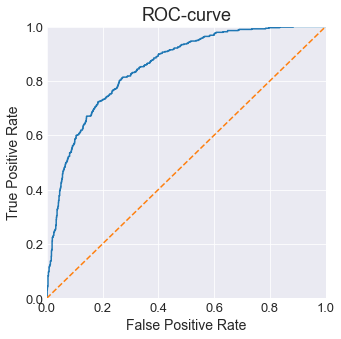

In [27]:
svc = SVC(class_weight='balanced', probability=True, kernel='linear', random_state=12345)
test_model(svc, 'SVC')

In [28]:
kn = KNeighborsClassifier()
kn_params = {'n_neighbors': list(range(3, 104, 10)), 'weights': ['uniform', 'distance']}
grid_search(kn, kn_params)

ROC-AUC score: 0.8347385269035406
Best parameters {'n_neighbors': 53, 'weights': 'uniform'}


           KNeighbors
Accuracy     0.812287
Recall       0.616702
Precision    0.656036
F1           0.635762
ROC-AUC      0.847521


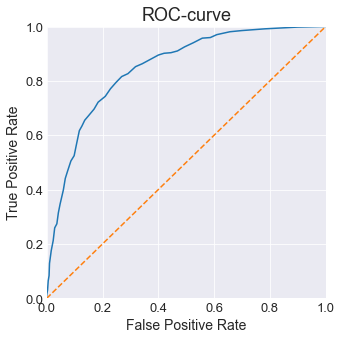

In [29]:
kn = KNeighborsClassifier(n_neighbors=53, weights='uniform', n_jobs=-1)
test_model(kn, 'KNeighbors')

In [30]:
forest = RandomForestClassifier(class_weight='balanced', random_state=12345, n_jobs=-1)
forest_params = {'n_estimators': np.arange(50, 101, 10),
                 'max_depth': list(range(15, 51, 5)),
                 'min_samples_leaf': list(range(1, 32, 2)),
                 'min_samples_split': list(range(2, 21, 2)),
                 'max_features' : ('log2', 'sqrt')}

random_search(forest, forest_params)

ROC-AUC score: 0.8437538865256885
Best parameters {'n_estimators': 70, 'min_samples_split': 14, 'min_samples_leaf': 21, 'max_features': 'log2', 'max_depth': 25}


             Forest
Accuracy   0.762799
Recall     0.800857
Precision  0.535817
F1         0.642060
ROC-AUC    0.851317


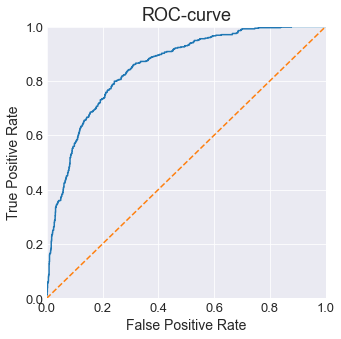

In [31]:
forest_params = {'n_estimators': 70, 'min_samples_split': 14, 'min_samples_leaf': 21, 
                 'max_features': 'log2', 'max_depth': 25}
forest = RandomForestClassifier(**forest_params, class_weight='balanced', random_state=12345, n_jobs=-1)

test_model(forest, 'Forest')

In [32]:
gbm = lgb.LGBMClassifier(class_weight='balanced', random_state=12345, n_estimators=166, n_jobs=-1)
gbm_params = {'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

random_search(gbm, gbm_params)

ROC-AUC score: 0.8470446505038837
Best parameters {'colsample_bytree': 0.899139582483121, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 335, 'min_child_weight': 10.0, 'num_leaves': 16, 'reg_alpha': 10, 'reg_lambda': 10, 'subsample': 0.8546800091119315}


               LGBM
Accuracy   0.758817
Recall     0.800857
Precision  0.530496
F1         0.638225
ROC-AUC    0.852626


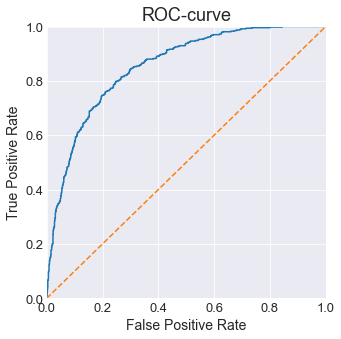

In [33]:
gbm_params =  {'colsample_bytree': 0.899139582483121, 'learning_rate': 0.1, 'max_depth': -1, 
               'min_child_samples': 3, 'min_child_weight': 10.0, 'num_leaves': 16, 'reg_alpha': 10, 
               'reg_lambda': 10, 'subsample': 0.8546800091119315}

gbm = lgb.LGBMClassifier(**gbm_params, class_weight='balanced', random_state=12345, n_jobs=-1)
                         
test_model(gbm, 'LGBM')

In [34]:
assessment

,LogReg,SVC,KNeighbors,Forest,LGBM
Accuracy,0.746303,0.704778,0.812287,0.762799,0.758817
Recall,0.813704,0.852248,0.616702,0.800857,0.800857
Precision,0.514208,0.469340,0.656036,0.535817,0.530496
F1,0.630182,0.605323,0.635762,0.642060,0.638225
ROC-AUC,0.853052,0.850541,0.847521,0.851317,0.852626


В целом, все модели показали примерно одинаковые результаты по целевой метрике. Хорошие результаты логистической регрессии и метода опорных векторов говорят о том, что классы делятся линейно. Если бы пришлось выбирать какую-то одну модель для работы, то я бы отдал предпочтение логистической регресси  - при одинаковых показателях она проще и быстрее в работе. Но попытаемся еще немного увеличить метрики. С ROC-AUC у нас уже врядли получится что-то сделать, а с отстальными можно поработать.

# 6. Анализ работы моделей и улучшение показателей метрик

Для начала взглянем на вклад признаков в предсказания.

In [35]:
def plot_features(fi, name):
    fi = pd.DataFrame({'Features': X_train.columns.tolist(), 
                  'Importance': abs(fi)}).sort_values('Importance', ascending=False)
    plt.figure(figsize=(8,8))
    sns.barplot(x='Importance', y='Features', data=fi)
    plt.title(name)
    plt.show()

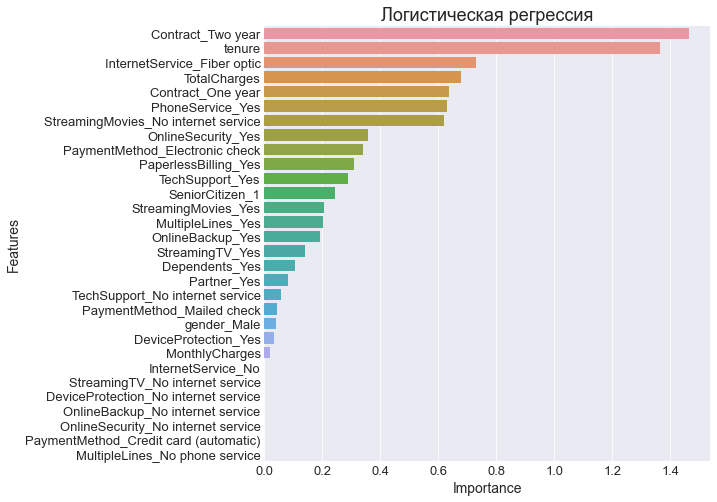

In [36]:
plot_features(logreg.coef_[0], 'Логистическая регрессия')

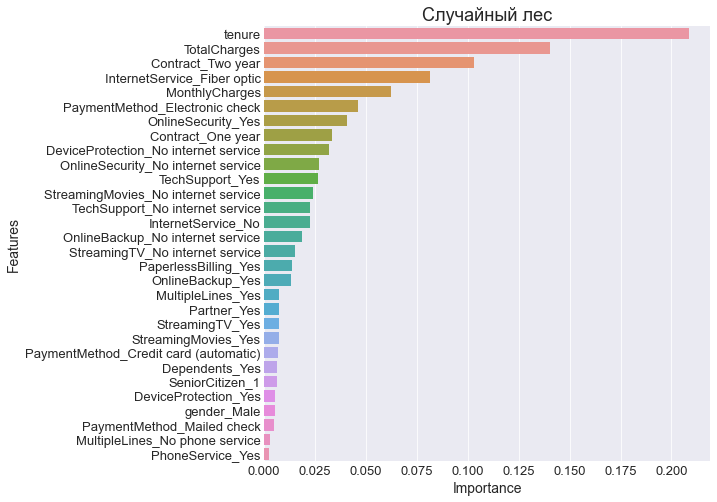

In [37]:
plot_features(forest.feature_importances_, 'Случайный лес')

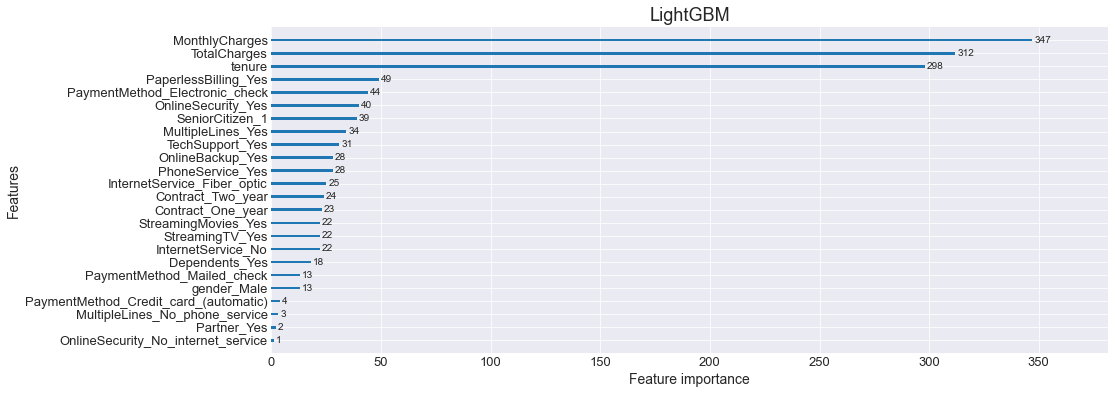

In [38]:
lgb.plot_importance(gbm)
plt.title('LightGBM');

Важность признаков у логистической регрессии довольно сильно отличается от важности у деревьев. Также интересно то, что в логистической регрессии мы использовали l1-регулеризацию, которая может занулять линейно зависимые коэфициенты. Так вес Monthly Charges у логистической регрессии близок к нулю - это говорит, что модель самостоятельно неплохо справляется с мультиколлинеарностью.

Теперь попробуем объеденить усилия всех моделей с помощью стакинга реализованного с помощью библиотеки skscikit-learn.

              Stack
Accuracy   0.755404
Recall     0.800857
Precision  0.526020
F1         0.634975
ROC-AUC    0.855771


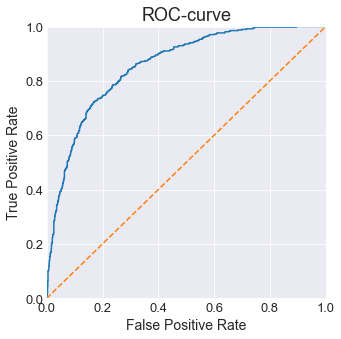

In [39]:
estimators = [('LogReg', logreg), ('SVC', svc), ('KNeighbors', kn), ('Forest', forest),('LGBM', gbm)]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(class_weight='balanced'), 
                           n_jobs=-1, cv=3)
test_model(stack, 'Stack')

In [40]:
assessment

,LogReg,SVC,KNeighbors,Forest,LGBM,Stack
Accuracy,0.746303,0.704778,0.812287,0.762799,0.758817,0.755404
Recall,0.813704,0.852248,0.616702,0.800857,0.800857,0.800857
Precision,0.514208,0.469340,0.656036,0.535817,0.530496,0.526020
F1,0.630182,0.605323,0.635762,0.642060,0.638225,0.634975
ROC-AUC,0.853052,0.850541,0.847521,0.851317,0.852626,0.855771


Ансамбль показал немного лучший результат, чем все модели по отдельности, но чуда не произошло. Остается только попробовать увеличить Accuracy, изменив порог отнесения к первому классу.

In [41]:
def find_threshold(model, X, y):
    accuracies, thresholds = [], []
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    kf = KFold(n_splits=3)
    kf.get_n_splits(X)
    for train_index, test_index in kf.split(X):
        X_1, X_2 = X.loc[train_index], X.loc[test_index]
        y_1, y_2 = y.loc[train_index], y.loc[test_index]
        model.fit(X_1, y_1)
        probabilities = model.predict_proba(X_2)[:, 1]
        best_accuracy, best_threshold = 0, 0
        for threshold in np.arange(0.3, 0.9, 0.05):
            predictions = (probabilities > threshold).astype('int')
            accuracy = accuracy_score(y_2, predictions)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_threshold = threshold
        accuracies.append(round(best_accuracy, 3))
        thresholds.append(round(best_threshold, 2))
    print(accuracies)
    print(thresholds)
    
find_threshold(stack, X_train, y_train)

[0.794, 0.811, 0.815]
[0.7, 0.75, 0.8]


              Final
Accuracy   0.816268
Recall     0.584582
Precision  0.679104
F1         0.628308
ROC-AUC    0.855830


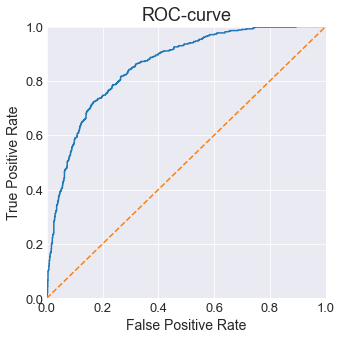

In [42]:
test_model(stack, 'Final', 0.75)

In [43]:
assessment

,LogReg,SVC,KNeighbors,Forest,LGBM,Stack,Final
Accuracy,0.746303,0.704778,0.812287,0.762799,0.758817,0.755404,0.816268
Recall,0.813704,0.852248,0.616702,0.800857,0.800857,0.800857,0.584582
Precision,0.514208,0.469340,0.656036,0.535817,0.530496,0.526020,0.679104
F1,0.630182,0.605323,0.635762,0.642060,0.638225,0.634975,0.628308
ROC-AUC,0.853052,0.850541,0.847521,0.851317,0.852626,0.855771,0.855830


Итого. Максимальное значение целевой метрики ROC-AUC - 0,856. Значение Accuracy - 0,816.

## 7. Дополнительные замечания по проекту

В процессе работы над проектом:

- Параллельно прямому кодированию категориальных признаков использовалось порядковое для некоторых моделей.
- Для борьбы с дисбалансом был применен апсэмпелинг.
- При обработке данных была проведена кластеризация пользователей методом к-средних и добавлена дополнительная фича с номером кластера. Идея была в том, чтобы дополнительно помочь моделям находить закономерности таким образом.
- С помощью жадного алгоритма для каждой модели отбиралось меньшее количество признаков, для которых значение метрики было максимально на кросс-валидации.

Но все эти меры не улучшали показатели, поэтому от них было решено отказаться.

# Общий вывод

Перед нами стояла задача предсказания оттока клиентов. По другому - бинарной классификации, с предсказанием к какому классу относится абонент - ушедшему или нет. Целевой метрикой была выбрана ROC-AUC, дополнительной - Accuracy. Оказалось, что классы в данных относительно хорошо делятся линейно, поэтому линейная регрессия и метод опорных векторов показали хорошие результаты. Более сложные модели не смогли добиться лучших показателей, поэтому для работы я бы выбрал регрессию как менее затратный алгоритм. 

Анализ важности признаков показал, что в первую очередь модели опираются на продолжительность использования услуг, траты полизователй и период абонентской платы.

Длительность и период оплаты - легко интерпретируемые признаки, чем дольше абонент пользуется оператом, тем меньше вероятность его ухода. 

С ежемесячными и, следовательно, общими тратами картина интереснее. При визуализации, была замечена некоторая сегментация абонентов. Возможно, стоит разбить клиентов на три категории по тратам (например - эконом, базовая и премиум) и работать с ними по отдельности, разрабатывая свои стратегии и бюджет для удержания клиентов из каждой из них. Особенно важно отметить, что доля абонентов с высоким тратами среди ушидших гораздо больше, чем среди тех кто остался.

Еще стоит обратить внимание на способ подключения абонентов к интернету. Важность этого признака высока. И мы также наблюдали, что доля ушедших клиентов с подключением по оптоволокну несколько выше. Стоит дополнительно провести исследования, возможно есть технические проблемы, которые влияют на лояльность клиентов.